# Part 3 – MIT‑BIH ECG Beat Classification
A full pipeline for loading the **MIT‑BIH Arrhythmia Database**, extracting beat windows, training a simple neural network, and evaluating its clinical performance.

## Setup & Installation

In [10]:

# !pip install wfdb tensorflow scikit-learn matplotlib seaborn --quiet

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, json, urllib.request, zipfile, wfdb
from scipy import signal
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

tf.random.set_seed(42); np.random.seed(42)
plt.style.use('seaborn-v0_8'); plt.rcParams.update({'figure.figsize':(12,8)})

os.makedirs('models', exist_ok=True)
os.makedirs('results/part_3', exist_ok=True)
os.makedirs('data', exist_ok=True)


## 1. Download MIT‑BIH Arrhythmia Database

In [2]:

data_dir = 'data/mitdb'
if not os.path.exists(data_dir):
    print('Downloading MIT‑BIH Arrhythmia Database…')
    url = 'https://www.physionet.org/static/published-projects/mitdb/mit-bih-arrhythmia-database-1.0.0.zip'
    zip_path = 'data/mitdb.zip'
    urllib.request.urlretrieve(url, zip_path)
    with zipfile.ZipFile(zip_path, 'r') as zf:
        zf.extractall('data')
    os.remove(zip_path)
    print('Done.')
else:
    print('Dataset already present.')


Done.


## 2. Data Loading & Visualisation

Signals shape: (650000, 2)
Annotations   : 2274 unique: ['+' 'A' 'N' 'V']


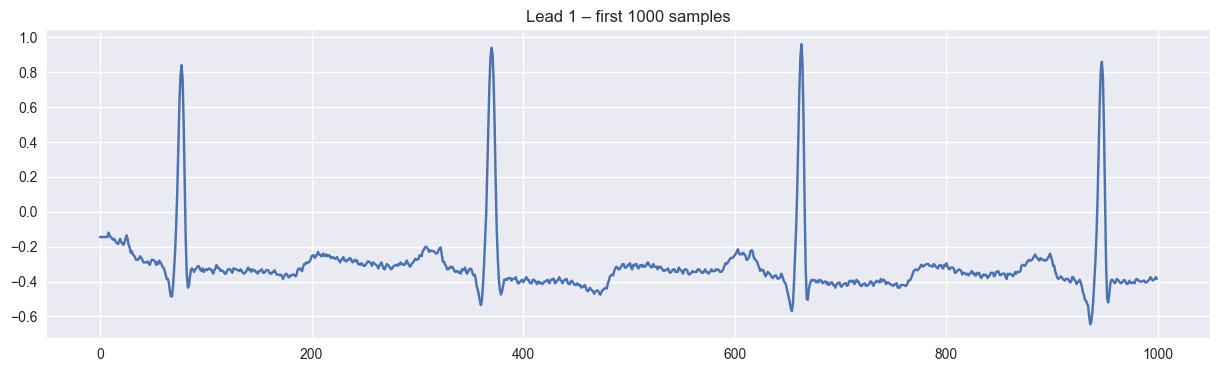

In [11]:

record_path = 'data/mit-bih-arrhythmia-database-1.0.0/100'  # sample record
rec = wfdb.rdrecord(record_path)
signals = rec.p_signal        # shape (N, 2)
ann  = wfdb.rdann(record_path, 'atr')
symbols = ann.symbol

print('Signals shape:', signals.shape)
print('Annotations   :', len(symbols), 'unique:', np.unique(symbols))

plt.figure(figsize=(15,4))
plt.plot(signals[:1000,0])
plt.title('Lead 1 – first 1000 samples')
plt.show()


### Beat Window Extraction

Dataset shape: (2273, 180, 2)    Positives: 34


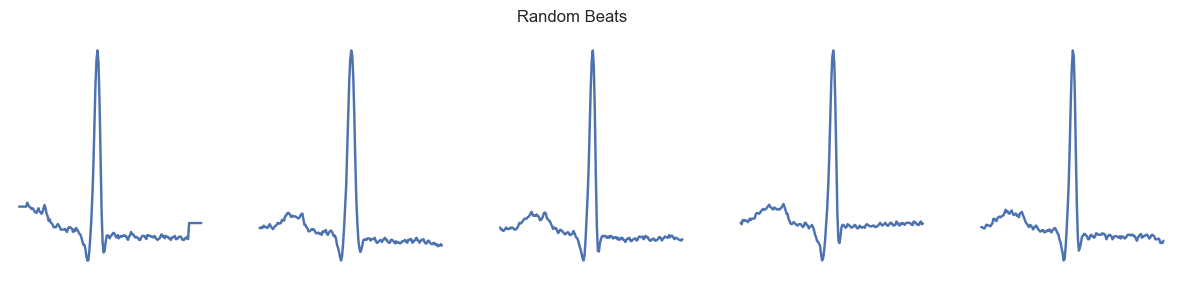

In [12]:

window = 180
sig_norm = (signals - np.mean(signals)) / np.std(signals)

X, y = [], []
for idx, sym in zip(ann.sample, symbols):
    if sym in ['N','L','R','A','V']:             # keep common beats
        start = max(0, idx - window//2)
        end   = min(len(sig_norm), idx + window//2)
        segment = sig_norm[start:end]
        # pad
        if len(segment) < window:
            pad = window - len(segment)
            segment = np.pad(segment, ((0,pad), (0,0)))
        X.append(segment)
        y.append(0 if sym=='N' else 1)

X = np.array(X)          # (num_beats, window, 2)
y = np.array(y)
print('Dataset shape:', X.shape, '   Positives:', y.sum())

# quick plot
plt.figure(figsize=(15,3))
for i in range(5):
    plt.subplot(1,5,i+1); plt.plot(X[i,:,0]); plt.axis('off')
plt.suptitle('Random Beats'); plt.show()


In [13]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val,  y_train, y_val  = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

print('Train:', X_train.shape, ' Val:', X_val.shape, ' Test:', X_test.shape)


Train: (1454, 180, 2)  Val: (364, 180, 2)  Test: (455, 180, 2)


## 3. Model – Simple 1‑D CNN + Dense

In [18]:

def create_ecg_nn(input_shape=(180,2), dropout=0.3, lr=1e-3):
    inputs = tf.keras.Input(shape=input_shape)
    x = tf.keras.layers.Conv1D(32, 5, activation='relu')(inputs)
    x = tf.keras.layers.MaxPooling1D(2)(x)
    x = tf.keras.layers.Conv1D(64, 5, activation='relu')(x)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(lr),
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
    return model

model = create_ecg_nn()
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 180, 2)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 176, 32)        │           352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 88, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 84, 64)         │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_3      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,881 (58.13 KB)

 Trainable params: 14,881 (58.13 KB)

 Non-trainable params: 0 (0.00 B)

### Training

In [19]:

cbs = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3),
    tf.keras.callbacks.ModelCheckpoint('models/ecg_classifier.keras', save_best_only=True)
]
hist = model.fit(X_train, y_train,
                 validation_data=(X_val, y_val),
                 epochs=20,
                 batch_size=256,
                 callbacks=cbs,
                 verbose=2)


Epoch 1/20
6/6 - 1s - 208ms/step - accuracy: 0.8673 - auc: 0.4876 - loss: 0.5676 - val_accuracy: 0.9863 - val_auc: 0.6017 - val_loss: 0.3905 - learning_rate: 1.0000e-03
Epoch 2/20
6/6 - 0s - 22ms/step - accuracy: 0.9849 - auc: 0.4939 - loss: 0.3020 - val_accuracy: 0.9863 - val_auc: 0.6125 - val_loss: 0.1687 - learning_rate: 1.0000e-03
Epoch 3/20
6/6 - 0s - 25ms/step - accuracy: 0.9849 - auc: 0.4204 - loss: 0.1390 - val_accuracy: 0.9863 - val_auc: 0.6175 - val_loss: 0.0797 - learning_rate: 1.0000e-03
Epoch 4/20
6/6 - 0s - 27ms/step - accuracy: 0.9849 - auc: 0.4515 - loss: 0.0938 - val_accuracy: 0.9863 - val_auc: 0.6189 - val_loss: 0.0728 - learning_rate: 1.0000e-03
Epoch 5/20
6/6 - 0s - 27ms/step - accuracy: 0.9849 - auc: 0.4525 - loss: 0.0971 - val_accuracy: 0.9863 - val_auc: 0.4883 - val_loss: 0.0775 - learning_rate: 1.0000e-03
Epoch 6/20
6/6 - 0s - 23ms/step - accuracy: 0.9849 - auc: 0.4971 - loss: 0.0972 - val_accuracy: 0.9863 - val_auc: 0.5017 - val_loss: 0.0767 - learning_rate: 1.

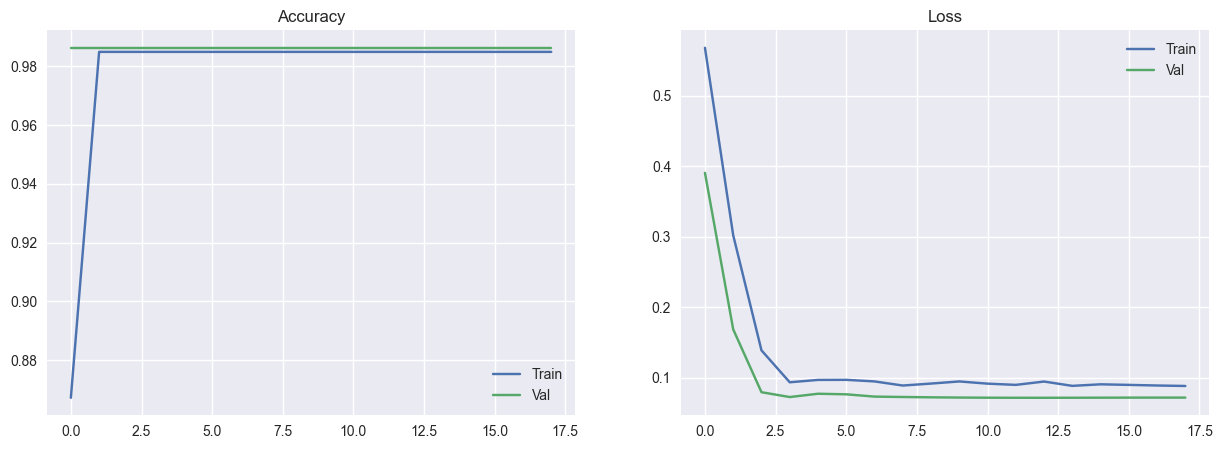

In [20]:

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(hist.history['accuracy'],label='Train')
ax1.plot(hist.history['val_accuracy'],label='Val')
ax1.set_title('Accuracy'); ax1.legend()

ax2.plot(hist.history['loss'],label='Train')
ax2.plot(hist.history['val_loss'],label='Val')
ax2.set_title('Loss'); ax2.legend()
plt.show()


### Evaluation

Test accuracy: 0.9846  |  AUC: 0.4646
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


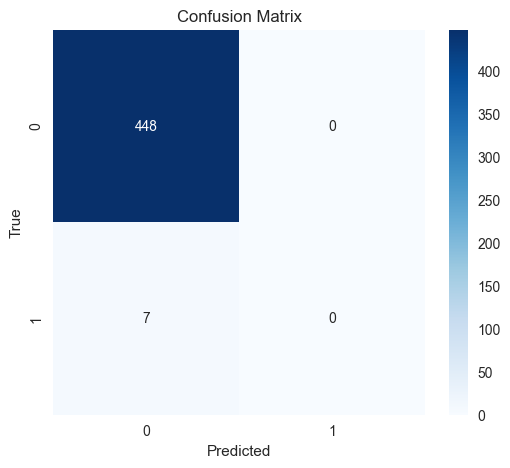

In [21]:

test_loss, test_acc, test_auc = model.evaluate(X_test, y_test, verbose=0)
print(f'Test accuracy: {test_acc:.4f}  |  AUC: {test_auc:.4f}')

y_prob = model.predict(X_test, batch_size=1024).ravel()
y_pred = (y_prob > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
precision = tp/(tp+fp+1e-8)
recall    = tp/(tp+fn+1e-8)
f1        = 2*precision*recall/(precision+recall+1e-8)

plt.figure(figsize=(6,5))
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues')
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion Matrix')
plt.show()

metrics = {
    'model': 'ecg_classifier',
    'accuracy': float(test_acc),
    'auc': float(test_auc),
    'precision': float(precision),
    'recall': float(recall),
    'f1_score': float(f1),
    'confusion_matrix': cm.tolist()
}
with open('results/part_3/ecg_classifier_metrics.txt', 'w') as f:
    f.write(f"model: {metrics['model']}\n")
    f.write(f"accuracy: {metrics['accuracy']}\n")
    f.write(f"precision: {metrics['precision']}\n")
    f.write(f"recall: {metrics['recall']}\n")
    f.write(f"f1_score: {metrics['f1_score']}\n")
    f.write(f"confusion_matrix: {metrics['confusion_matrix']}\n")
    f.write("----\n")
